# Capstone: Philosophical Factors for NLP
**_Measuring Similarity to Philosophical Concepts in Text Data_**

## Thomas W. Ludlow, Jr.
**General Assembly Data Science Immersive DSI-NY-6**

**February 12, 2019**

# Notebook 4 - Multiclass Classifier Models

### Table of Contents

[**4.1 Data Preparation**](#4.1-Data-Preparation)
- [4.1.1 Define X and y](#4.1.1-Define-X-and-y)
- [4.1.2 Standardize and Weight](#4.1.2-Standardize-and-Weight)

[**4.2 Logistic Regression**](#4.2-Logistic-Regression)
- [4.2.1 Logistic Regression Assembly](#4.2.1-Logistic-Regression-Assembly)
- [4.2.2 Logistic Regression Optimization](#4.2.2-Logistic-Regression-Optimization)

[**4.3 Recurrent Neural Net**](#4.4-Recurrent-Neural-Net)
- [4.3.1 Keras FFRNN Assembly](#4.4.1-Keras-FFRNN-Assembly)
- [4.3.2 Keras FFRNN Optimization](#4.4.2-Keras-FFRNN-Optimization)

**Libraries**

In [1]:
# Python Data Science
import re
import ast
import time
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm

# Natural Language Processing
import spacy
import gensim
import pyLDAvis.gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, ldamulticore, CoherenceModel

# Modeling Prep
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import class_weight

# Neural Net
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Override deprecation warnings
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

Using TensorFlow backend.


## 4.1 Data Preparation

**Load Train and Test Data**

In [2]:
prep_train = pd.read_csv('../data_vec/prep_train.csv')
prep_test = pd.read_csv('../data_vec/prep_test.csv')

In [3]:
prep_train.shape

(63932, 99)

In [4]:
prep_train.head()

,s_vec_0,s_vec_1,s_vec_2,s_vec_3,s_vec_4,s_vec_5,s_vec_6,s_vec_7,s_vec_8,s_vec_9,...,p9_lda_civil,p10_lda_deadites,p11_lda_idea,p12_lda_love,p13_lda_sense,p14_lda_biomolecular,p15_lda_thee,a_num,p_num,s_num
0,0.005141,0.007563,-0.005119,0.003487,0.014759,-0.000401,-0.013146,-0.010836,0.013186,0.000359,...,0.012991,0.012991,0.805130,0.012991,0.012991,0.012991,0.012991,0,0,0
1,0.000672,-0.008255,0.004202,0.012191,-0.008325,0.010428,-0.010309,0.007246,0.000948,0.013675,...,0.012991,0.012991,0.805130,0.012991,0.012991,0.012991,0.012991,0,0,1
2,0.009192,0.003800,0.004282,0.003132,0.009840,0.002502,-0.015351,-0.012835,0.005541,-0.002684,...,0.012991,0.012991,0.805130,0.012991,0.012991,0.012991,0.012991,0,0,2
3,0.012862,0.005095,0.007222,-0.000288,0.005181,0.011893,-0.000838,-0.004347,0.000892,-0.013354,...,0.013657,0.013657,0.013657,0.013657,0.736205,0.013657,0.013657,0,1,0
4,0.005489,-0.004147,-0.003460,-0.008962,0.004228,-0.000990,-0.011614,-0.008368,0.003744,0.005757,...,0.013657,0.013657,0.013657,0.013657,0.735830,0.013657,0.013657,0,1,1


In [5]:
prep_test.shape

(7935, 99)

In [6]:
prep_test.head()

,s_vec_0,s_vec_1,s_vec_2,s_vec_3,s_vec_4,s_vec_5,s_vec_6,s_vec_7,s_vec_8,s_vec_9,...,p9_lda_civil,p10_lda_deadites,p11_lda_idea,p12_lda_love,p13_lda_sense,p14_lda_biomolecular,p15_lda_thee,a_num,p_num,s_num
0,0.012852,-0.000564,0.000924,0.015578,-0.009460,-0.001825,0.006729,0.014028,-0.012019,-0.005941,...,0.012556,0.012556,0.012556,0.012556,0.267877,0.012556,0.012556,0,0,0
1,0.014496,-0.015362,-0.008466,0.012413,0.012671,-0.000903,0.015530,-0.005830,-0.007259,0.014899,...,0.011455,0.011455,0.147549,0.011455,0.011455,0.011455,0.011455,0,1,0
2,-0.005569,0.010911,0.007000,0.004631,0.000567,0.012376,0.001706,-0.012309,0.000371,0.012049,...,0.011455,0.011455,0.147652,0.011455,0.011455,0.011455,0.011455,0,1,1
3,0.012320,-0.007913,-0.014627,-0.005808,-0.004552,0.002174,-0.012969,0.000185,-0.009987,-0.009841,...,0.012644,0.012644,0.012644,0.012644,0.012644,0.012644,0.012644,0,2,0
4,0.001876,-0.003734,-0.006766,-0.008286,0.006277,-0.012269,-0.003850,-0.011094,0.013328,0.011740,...,0.015147,0.015147,0.015147,0.015147,0.015148,0.015147,0.015147,0,3,0


In [7]:
prep_test.tail()

,s_vec_0,s_vec_1,s_vec_2,s_vec_3,s_vec_4,s_vec_5,s_vec_6,s_vec_7,s_vec_8,s_vec_9,...,p9_lda_civil,p10_lda_deadites,p11_lda_idea,p12_lda_love,p13_lda_sense,p14_lda_biomolecular,p15_lda_thee,a_num,p_num,s_num
7930,-0.006734,0.011162,0.009488,-0.008400,-0.010261,-0.010349,-0.011043,0.010268,-0.007921,-0.014453,...,0.000000,0.000000,0.000000,0.158337,0.000000,0.029041,0.201526,16,83,1
7931,0.012661,-0.008760,-0.008574,-0.010942,0.009893,-0.002269,-0.000573,-0.009278,-0.014053,-0.005179,...,0.000000,0.000000,0.000000,0.158665,0.000000,0.028997,0.201952,16,83,2
7932,-0.015370,0.013310,-0.009113,0.002124,-0.010596,-0.002114,0.003677,0.011908,-0.007208,-0.006414,...,0.000000,0.000000,0.000000,0.158550,0.000000,0.029009,0.201803,16,83,3
7933,-0.002627,-0.011851,0.002627,-0.002608,0.009272,-0.013032,-0.010604,0.009540,-0.007297,-0.007836,...,0.012244,0.012244,0.012244,0.466041,0.012244,0.012244,0.247581,16,84,0
7934,-0.004780,-0.000294,-0.002042,0.013785,0.015297,-0.000199,-0.004119,-0.002273,0.001138,-0.005124,...,0.012244,0.012244,0.012244,0.465861,0.012244,0.012244,0.247772,16,84,1


### 4.1.1 Define X and y

In [8]:
X_train = prep_train.drop(['a_num'], axis=1)
X_test = prep_test.drop(['a_num'], axis=1)
y_train = prep_train.a_num
y_train_d = pd.get_dummies(prep_train['a_num'])
y_test = prep_test.a_num

In [9]:
adj_y = prep_test.a_num

In [10]:
adj_y.value_counts()

5     2407
13     720
9      663
14     549
16     515
10     438
15     410
12     346
4      333
2      329
3      307
0      230
11     175
1      160
6      131
8      130
7       92
Name: a_num, dtype: int64

In [11]:
adj_y += 3

In [12]:
adj_y.loc[adj_y[adj_y<=18].index] -= 1 # Sun Tzu

In [13]:
adj_y.loc[adj_y[adj_y<=8].index] -= 1 # Khayyam

In [14]:
adj_y.loc[adj_y[adj_y<=4].index] -= 1 # Hobbes

In [15]:
adj_y.unique()

array([ 0,  1,  2,  3,  5,  6,  7,  9, 10, 11, 12, 13, 14, 15, 16, 17, 19])

In [16]:
y_test_d = pd.get_dummies(adj_y)

In [17]:
add_nums = [4,8,18]
for num in add_nums:
    y_test_d[num] = 0

In [18]:
y_test_d.head()

,0,1,2,3,5,6,7,9,10,11,12,13,14,15,16,17,19,4,8,18
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
y_test_d = y_test_d[list(range(20))]

In [20]:
X_test.shape

(7935, 98)

In [21]:
y_test.shape

(7935,)

### 4.1.2 Standardize and Weight

**Standardize X Features**

In [22]:
ss = StandardScaler()

In [23]:
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [24]:
X_train_sc.shape

(63932, 98)

In [25]:
X_test_sc.shape

(7935, 98)

In [26]:
y_train.shape

(63932,)

In [27]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: a_num, dtype: int64

In [28]:
y_test.shape

(7935,)

In [29]:
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: a_num, dtype: int64

In [30]:
y_train.shape

(63932,)

**Weights**

In [31]:
class_weights = {i:val for i, val in y_train.value_counts(sort=False).iteritems()}

In [32]:
class_weights

{0: 1111,
 1: 1955,
 2: 1205,
 3: 569,
 4: 6160,
 5: 1566,
 6: 2492,
 7: 6067,
 8: 224,
 9: 8417,
 10: 1159,
 11: 7556,
 12: 5497,
 13: 3982,
 14: 2631,
 15: 3171,
 16: 3426,
 17: 3910,
 18: 1715,
 19: 1119}

## 4.2 Logistic Regression

### 4.2.1 Logistic Regression Assembly

In [64]:
lr_runs = pd.DataFrame(columns=['train_accuracy','test_accuracy','params'])

In [65]:
lr_single = {}

In [66]:
logreg = LogisticRegression(penalty='l2', random_state=211, n_jobs=3, 
                            multi_class='multinomial', solver='lbfgs', 
                            class_weight='balanced')


In [67]:
X_train_sc.shape

(63932, 98)

In [68]:
y_train.shape

(63932,)

In [69]:
logreg.fit(X_train_sc, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=3, penalty='l2',
          random_state=211, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [70]:
lr_single['train_accuracy'] = logreg.score(X_train_sc, y_train)
lr_single['test_accuracy'] = logreg.score(X_test_sc, y_test)
lr_single['params'] = {'penalty':logreg.penalty, 'C':logreg.C, 'solver':logreg.solver}

In [71]:
lr_single

{'train_accuracy': 0.5724832634674342,
 'test_accuracy': 0.14984247006931317,
 'params': {'penalty': 'l2', 'C': 1.0, 'solver': 'lbfgs'}}

### 4.2.2 Logistic Regression Optimization

**Parameters**

In [84]:
lr_single = {}

In [85]:
lr_params = {
    'penalty':['l2'],
    'C':np.arange(.005, .05, .001),
    'solver':['lbfgs'],
    'class_weight':['balanced'],
    'multi_class':['multinomial'],
    'n_jobs':[3]
}

In [86]:
grid = GridSearchCV(logreg, lr_params, cv=3)
grid.fit(X_train_sc, y_train)
lr_single['train_accuracy'] = grid.score(X_train_sc, y_train)
lr_single['test_accuracy'] = grid.score(X_test_sc, y_test)
lr_single['params'] = grid.best_params_

In [87]:
lr_runs = lr_runs.append(lr_single, ignore_index=True)

In [88]:
lr_runs

,train_accuracy,test_accuracy,params
0,0.569199,0.148834,"{'C': 0.1, 'class_weight': 'balanced', 'multi_..."
1,0.553588,0.144549,"{'C': 0.01, 'class_weight': 'balanced', 'multi..."
2,0.546049,0.146314,"{'C': 0.005, 'class_weight': 'balanced', 'mult..."


**Final Logistic Regression Model**

In [89]:
logreg = LogisticRegression(C=0.1, penalty='l2', random_state=211, n_jobs=3, 
                            multi_class='multinomial', solver='lbfgs', 
                            class_weight='balanced')

In [90]:
logreg.fit(X_train_sc, y_train)

LogisticRegression(C=0.1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='multinomial', n_jobs=3, penalty='l2',
          random_state=211, solver='lbfgs', tol=0.0001, verbose=0,
          warm_start=False)

In [91]:
logreg.score(X_test_sc, y_test)

0.14883427851291745

**Save Final Logistic Regression to Disk**

In [92]:
joblib.dump(logreg, '../models/logreg')
 
# some time later...
 
# load the model from disk
#logreg = joblib.load('./models/logreg')

['../models/logreg']

## 4.3 Recurrent Neural Net

### 4.3.1 Keras FFRNN Assembly

**RNN Parameters**

In [33]:
dropout_pct = .25
dense_1_nodes = 64
dense_2_nodes = 128
dense_3_nodes = 64
target_nodes = 20
epochs = 50
batch_size = 1000
patience = 20

In [35]:
model = Sequential()
model.add(Dense(X_train_sc.shape[0], input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dropout(rate=dropout_pct))
model.add(Dense(dense_1_nodes, activation='relu'))
model.add(Dropout(rate=dropout_pct))
model.add(Dense(dense_2_nodes, activation='relu'))
model.add(Dropout(rate=dropout_pct))
model.add(Dense(dense_3_nodes, activation='relu'))
model.add(Dense(y_test_d.shape[1], activation=None))
model.add(Activation(tf.nn.softmax))

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=1, mode='auto')

In [38]:
history = model.fit(X_train_sc, 
                    y_train_d, 
                    validation_data=(X_test_sc, y_test_d), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[early_stop], 
                    class_weight=class_weights
                   )

Instructions for updating:
Use tf.cast instead.
Train on 63932 samples, validate on 7935 samples
Epoch 1/50
63932/63932 [==============================] - 9s 142us/step - loss: 7324.1542 - acc: 0.4097 - val_loss: 3.1172 - val_acc: 0.1061
Epoch 2/50
63932/63932 [==============================] - 7s 113us/step - loss: 5533.5788 - acc: 0.5070 - val_loss: 3.2161 - val_acc: 0.1086
Epoch 3/50
63932/63932 [==============================] - 7s 114us/step - loss: 5000.9352 - acc: 0.5387 - val_loss: 3.1638 - val_acc: 0.1183
Epoch 4/50
63932/63932 [==============================] - 7s 113us/step - loss: 4610.8830 - acc: 0.5653 - val_loss: 3.0923 - val_acc: 0.1318
Epoch 5/50
63932/63932 [==============================] - 7s 114us/step - loss: 4314.5498 - acc: 0.5843 - val_loss: 3.2689 - val_acc: 0.1395
Epoch 6/50
63932/63932 [==============================] - 7s 114us/step - loss: 3994.5395 - acc: 0.6041 - val_loss: 3.3451 - val_acc: 0.1207
Epoch 7/50
63932/63932 [==============================] -

**With Class Weights**

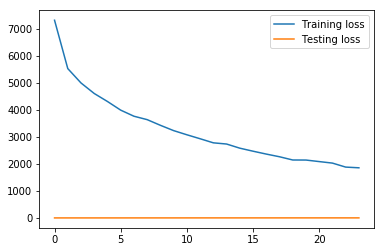

In [39]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

### 4.4.2 Keras FFRNN Optimization

Dropout percentage searched manually over terms:

`.5, .45, .4, .35, .3, .25, .2, .15, .1, .05, 0`

In [40]:
rnn_opt_params = {
    'dropout_pct' : [0],
    'dense_1_nodes' : [128, 256],
    'dense_2_nodes' : [64, 128],
    'dense_3_nodes' : [32, 64],
    'target_nodes' : [20],
    'epochs' : [30],
    'batch_size' : [1000],
    'patience' : [5]
}

In [41]:
rnn_df = pd.DataFrame(columns=['dropout_pct','dense_1_nodes','dense_2_nodes',
                               'dense_3_nodes','target_nodes','epochs','batch_size',
                               'patience'])
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for dp in rnn_opt_params['dropout_pct']:
    for d1 in rnn_opt_params['dense_1_nodes']:
        for d2 in rnn_opt_params['dense_2_nodes']:
            for d3 in rnn_opt_params['dense_3_nodes']:
                for tn in rnn_opt_params['target_nodes']:
                    for e in rnn_opt_params['epochs']:
                        for bs in rnn_opt_params['batch_size']:
                            for p in rnn_opt_params['patience']:
                                temp_df = pd.Series(index=['dropout_pct','dense_1_nodes','dense_2_nodes',
                                                                'dense_3_nodes','target_nodes','epochs',
                                                                'batch_size','patience'])
                                temp_df['dropout_pct'] = dp
                                temp_df['dense_1_nodes'] = d1
                                temp_df['dense_2_nodes'] = d2
                                temp_df['dense_3_nodes'] = d3
                                temp_df['target_nodes'] = tn
                                temp_df['epochs'] = e
                                temp_df['batch_size'] = bs
                                temp_df['patience'] = p
                                
                                model = Sequential()
                                model.add(Dense(X_train_sc.shape[0], input_dim=X_train_sc.shape[1], activation='relu'))
                                model.add(Dropout(rate=dp))
                                model.add(Dense(d1, activation='relu'))
                                model.add(Dropout(rate=dp))
                                model.add(Dense(d2, activation='relu'))
                                model.add(Dropout(rate=dp))
                                model.add(Dense(d3, activation='relu'))
                                model.add(Dense(y_test_d.shape[1], activation=None))
                                model.add(Activation(tf.nn.softmax))
                                model.compile(loss='categorical_crossentropy', 
                                              optimizer='adam', 
                                              metrics=['accuracy'], 
                                              weighted_metrics=['accuracy'])
                                early_stop = EarlyStopping(monitor='val_acc', 
                                                                min_delta=0, patience=p, 
                                                                verbose=0, mode='auto')
                                history = model.fit(X_train_sc, 
                                                    y_train_d, 
                                                    validation_data=(X_test_sc, y_test_d), 
                                                    epochs=e, 
                                                    batch_size=bs, 
                                                    callbacks=[early_stop], 
                                                    class_weight=class_weights, 
                                                    verbose=0)
                                
                                train_loss_list.append(history.history['loss'])
                                test_loss_list.append(history.history['val_loss'])
                                train_acc_list.append(history.history['acc'])
                                test_acc_list.append(history.history['val_acc'])
                                
                                rnn_df = rnn_df.append(temp_df, ignore_index=True)
                                print(temp_df)
                                print('Acc:',np.mean(history.history['acc']))
                                print('Val Acc:',np.mean(history.history['val_acc']))

rnn_df['train_loss'] = train_loss_list
rnn_df['test_loss'] = test_loss_list
rnn_df['train_acc'] = train_acc_list
rnn_df['test_acc'] = test_acc_list
rnn_df.head()

dropout_pct         0.0
dense_1_nodes     128.0
dense_2_nodes      64.0
dense_3_nodes      32.0
target_nodes       20.0
epochs             30.0
batch_size       1000.0
patience            5.0
dtype: float64
Acc: 0.7979399992676659
Val Acc: 0.15107750458972646
dropout_pct         0.0
dense_1_nodes     128.0
dense_2_nodes      64.0
dense_3_nodes      64.0
target_nodes       20.0
epochs             30.0
batch_size       1000.0
patience            5.0
dtype: float64
Acc: 0.7127041231162358
Val Acc: 0.14691871389695024
dropout_pct         0.0
dense_1_nodes     128.0
dense_2_nodes     128.0
dense_3_nodes      32.0
target_nodes       20.0
epochs             30.0
batch_size       1000.0
patience            5.0
dtype: float64
Acc: 0.7555788443471727
Val Acc: 0.1500525097400842
dropout_pct         0.0
dense_1_nodes     128.0
dense_2_nodes     128.0
dense_3_nodes      64.0
target_nodes       20.0
epochs             30.0
batch_size       1000.0
patience            5.0
dtype: float64
Acc: 0.6809090

,dropout_pct,dense_1_nodes,dense_2_nodes,dense_3_nodes,target_nodes,epochs,batch_size,patience,train_loss,test_loss,train_acc,test_acc
0,0.0,128.0,64.0,32.0,20.0,30.0,1000.0,5.0,"[7000.47649736732, 4675.093412697035, 3971.401...","[3.2396667289072867, 3.2491806166383856, 3.355...","[0.4410623776004057, 0.571231932609645, 0.6182...","[0.11644612221257372, 0.11291745199664029, 0.1..."
1,0.0,128.0,64.0,64.0,20.0,30.0,1000.0,5.0,"[6411.526916538275, 4326.956224729009, 3750.69...","[3.2980531997175886, 3.3142742964931458, 3.365...","[0.47545829559410346, 0.591738094907898, 0.635...","[0.11770636534814799, 0.1257718953068668, 0.15..."
2,0.0,128.0,128.0,32.0,20.0,30.0,1000.0,5.0,"[6981.225339276497, 4677.000521641891, 4014.63...","[3.30319941892666, 3.2115299261510186, 3.35187...","[0.4546549452488215, 0.5768629154544117, 0.616...","[0.12665406417127442, 0.13232514326928374, 0.1..."
3,0.0,128.0,128.0,64.0,20.0,30.0,1000.0,5.0,"[6289.711426636651, 4343.899238827485, 3696.32...","[3.3623245672828084, 3.6025079355798733, 3.438...","[0.4719858592271111, 0.5880310307163354, 0.637...","[0.13585381371467348, 0.11052299959781077, 0.1..."
4,0.0,256.0,64.0,32.0,20.0,30.0,1000.0,5.0,"[7743.777058382099, 4915.8313539556675, 4134.4...","[3.6170854648104536, 3.243385871702121, 3.5585...","[0.43496214673818107, 0.5569980636426447, 0.60...","[0.11039697907210129, 0.13144297359444357, 0.1..."


In [38]:
# rnn_runs_df = rnn_df

In [42]:
rnn_runs_df = rnn_runs_df.append(rnn_df).reset_index(drop=True)

In [43]:
rnn_runs_df.shape

(88, 12)

In [44]:
rnn_runs_df.tail()

,dropout_pct,dense_1_nodes,dense_2_nodes,dense_3_nodes,target_nodes,epochs,batch_size,patience,train_loss,test_loss,train_acc,test_acc
83,0.0,128.0,128.0,64.0,20.0,30.0,1000.0,5.0,"[6289.711426636651, 4343.899238827485, 3696.32...","[3.3623245672828084, 3.6025079355798733, 3.438...","[0.4719858592271111, 0.5880310307163354, 0.637...","[0.13585381371467348, 0.11052299959781077, 0.1..."
84,0.0,256.0,64.0,32.0,20.0,30.0,1000.0,5.0,"[7743.777058382099, 4915.8313539556675, 4134.4...","[3.6170854648104536, 3.243385871702121, 3.5585...","[0.43496214673818107, 0.5569980636426447, 0.60...","[0.11039697907210129, 0.13144297359444357, 0.1..."
85,0.0,256.0,64.0,64.0,20.0,30.0,1000.0,5.0,"[6351.177239830992, 4421.104237155787, 3779.57...","[3.4931962210649803, 3.091948292130709, 3.6197...","[0.47222048397271704, 0.5856065827653233, 0.63...","[0.10560806609558736, 0.18323881179094315, 0.1..."
86,0.0,256.0,128.0,32.0,20.0,30.0,1000.0,5.0,"[6742.465438742531, 4611.957481771404, 3943.60...","[3.386409793173508, 3.2864797131851473, 3.4490...","[0.4582525178750935, 0.5785052836526807, 0.625...","[0.1214870806506447, 0.12488972678048174, 0.13..."
87,0.0,256.0,128.0,64.0,20.0,30.0,1000.0,5.0,"[6236.77191583318, 4300.025955311894, 3648.506...","[3.3483060630673345, 3.270634562547055, 3.5625...","[0.4777419780118403, 0.5934273885828841, 0.641...","[0.13774416709780016, 0.13547573766301996, 0.1..."


**Save RNN Results DataFrame**

In [45]:
# rnn_runs_df.to_csv('../models/rnn_runs_df.csv', index=False)

**Load RNN Results DataFrame**

In [33]:
# rnn_runs_df = pd.read_csv('../models/rnn_runs_df.csv')
rnn_runs_df.tail()

,dropout_pct,dense_1_nodes,dense_2_nodes,dense_3_nodes,target_nodes,epochs,batch_size,patience,train_loss,test_loss,train_acc,test_acc
83,0.0,128.0,128.0,64.0,20.0,30.0,1000.0,5.0,"[6289.711426636651, 4343.899238827485, 3696.32...","[3.3623245672828084, 3.6025079355798733, 3.438...","[0.4719858592271111, 0.5880310307163354, 0.637...","[0.13585381371467348, 0.11052299959781077, 0.1..."
84,0.0,256.0,64.0,32.0,20.0,30.0,1000.0,5.0,"[7743.777058382099, 4915.8313539556675, 4134.4...","[3.6170854648104536, 3.243385871702121, 3.5585...","[0.43496214673818107, 0.5569980636426447, 0.60...","[0.11039697907210129, 0.13144297359444357, 0.1..."
85,0.0,256.0,64.0,64.0,20.0,30.0,1000.0,5.0,"[6351.177239830992, 4421.104237155787, 3779.57...","[3.4931962210649803, 3.091948292130709, 3.6197...","[0.47222048397271704, 0.5856065827653233, 0.63...","[0.10560806609558736, 0.18323881179094315, 0.1..."
86,0.0,256.0,128.0,32.0,20.0,30.0,1000.0,5.0,"[6742.465438742531, 4611.957481771404, 3943.60...","[3.386409793173508, 3.2864797131851473, 3.4490...","[0.4582525178750935, 0.5785052836526807, 0.625...","[0.1214870806506447, 0.12488972678048174, 0.13..."
87,0.0,256.0,128.0,64.0,20.0,30.0,1000.0,5.0,"[6236.77191583318, 4300.025955311894, 3648.506...","[3.3483060630673345, 3.270634562547055, 3.5625...","[0.4777419780118403, 0.5934273885828841, 0.641...","[0.13774416709780016, 0.13547573766301996, 0.1..."


**Re-run with Next Hyperparameter HERE --^**

In [56]:
rnn_runs_df['test_acc'].head()

0    [0.07208569589168978, 0.06452426048102493, 0.0...
1    [0.07536232139311952, 0.08128544497030782, 0.1...
2    [0.06175173280635061, 0.08998109674328855, 0.0...
3    [0.059861371879921854, 0.07561436773200943, 0....
4    [0.06402016511549627, 0.09023314575936409, 0.1...
Name: test_acc, dtype: object

In [59]:
eval_results = []

for r, result in rnn_runs_df['test_acc'].iteritems():
    eval_results.append(ast.literal_eval(result))

In [70]:
train_results = []

for r, result in rnn_runs_df['train_acc'].iteritems():
    train_results.append(ast.literal_eval(result))

In [74]:
res_df = pd.DataFrame(columns=['train_mean','train_max','test_mean','test_max'])

for i, res_list in enumerate(eval_results):
    res_df.loc[i, 'test_mean'] = np.mean(res_list)
    res_df.loc[i, 'test_max'] = np.max(res_list)
    
for j, train_list in enumerate(train_results):
    res_df.loc[j, 'train_mean'] = np.mean(train_list)
    res_df.loc[j, 'train_max'] = np.max(train_list)
    
res_df.head()

,train_mean,train_max,test_mean,test_max
0,0.488705,0.558844,0.10289,0.129175
1,0.555824,0.633329,0.10648,0.120605
2,0.487546,0.55789,0.103914,0.119471
3,0.51138,0.580554,0.103163,0.118336
4,0.574122,0.660389,0.114382,0.133207


In [77]:
res_df.sort_values(by='train_mean', ascending=False).head()

,train_mean,train_max,test_mean,test_max
86,0.800494,0.942783,0.150917,0.17782
80,0.79794,0.952543,0.151078,0.175299
78,0.791915,0.920681,0.148396,0.167234
62,0.762288,0.894294,0.143536,0.16925
82,0.755579,0.918648,0.150053,0.172275


In [79]:
res_df.sort_values(by='train_max', ascending=False).head()

,train_mean,train_max,test_mean,test_max
80,0.79794,0.952543,0.151078,0.175299
86,0.800494,0.942783,0.150917,0.17782
78,0.791915,0.920681,0.148396,0.167234
82,0.755579,0.918648,0.150053,0.172275
62,0.762288,0.894294,0.143536,0.16925


In [78]:
res_df.sort_values(by='test_mean', ascending=False).head()

,train_mean,train_max,test_mean,test_max
87,0.725339,0.880467,0.155791,0.188784
83,0.680909,0.81668,0.153749,0.175929
80,0.79794,0.952543,0.151078,0.175299
86,0.800494,0.942783,0.150917,0.17782
82,0.755579,0.918648,0.150053,0.172275


In [80]:
res_df.sort_values(by='test_max', ascending=False).head()

,train_mean,train_max,test_mean,test_max
87,0.725339,0.880467,0.155791,0.188784
85,0.655694,0.774338,0.137438,0.183239
81,0.712704,0.855737,0.146919,0.182231
86,0.800494,0.942783,0.150917,0.17782
64,0.652407,0.776309,0.145342,0.177316


Selecting run 86

**Highest Mean Accuracy Model**

In [35]:
# model number
mn = 86

In [36]:
rnn_runs_df.loc[mn]

dropout_pct                                                      0
dense_1_nodes                                                  256
dense_2_nodes                                                  128
dense_3_nodes                                                   32
target_nodes                                                    20
epochs                                                          30
batch_size                                                    1000
patience                                                         5
train_loss       [6742.465438742531, 4611.957481771404, 3943.60...
test_loss        [3.386409793173508, 3.2864797131851473, 3.4490...
train_acc        [0.4582525178750935, 0.5785052836526807, 0.625...
test_acc         [0.1214870806506447, 0.12488972678048174, 0.13...
Name: 86, dtype: object

In [37]:
rnn_runs_df.loc[mn]

dropout_pct                                                      0
dense_1_nodes                                                  256
dense_2_nodes                                                  128
dense_3_nodes                                                   32
target_nodes                                                    20
epochs                                                          30
batch_size                                                    1000
patience                                                         5
train_loss       [6742.465438742531, 4611.957481771404, 3943.60...
test_loss        [3.386409793173508, 3.2864797131851473, 3.4490...
train_acc        [0.4582525178750935, 0.5785052836526807, 0.625...
test_acc         [0.1214870806506447, 0.12488972678048174, 0.13...
Name: 86, dtype: object

In [38]:
dp = rnn_runs_df.loc[mn,'dropout_pct']
d1 = rnn_runs_df.loc[mn,'dense_1_nodes'].astype(int)
d2 = rnn_runs_df.loc[mn,'dense_2_nodes'].astype(int)
d3 = rnn_runs_df.loc[mn,'dense_3_nodes'].astype(int)
tn = rnn_runs_df.loc[mn,'target_nodes'].astype(int)
e = rnn_runs_df.loc[mn,'epochs'].astype(int)
bs = rnn_runs_df.loc[mn,'batch_size'].astype(int)
p = rnn_runs_df.loc[mn,'patience'].astype(int)

In [39]:
dp, d1, d2, d3, tn, e, bs, p

(0.0, 256, 128, 32, 20, 30, 1000, 5)

In [40]:
model = Sequential()
model.add(Dense(X_train_sc.shape[0], input_dim=X_train_sc.shape[1], activation='relu'))
model.add(Dropout(dp))
model.add(Dense(d1, activation='relu'))
model.add(Dropout(dp))
model.add(Dense(d2, activation='relu'))
model.add(Dropout(dp))
model.add(Dense(d3, activation='relu'))
model.add(Dense(y_test_d.shape[1], activation=None))
model.add(Activation(tf.nn.softmax))
model.compile(loss='categorical_crossentropy', 
                   optimizer='adam', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_acc', 
                                min_delta=0, patience=p, 
                                verbose=1, mode='auto')
history = model.fit(X_train_sc, 
                    y_train_d, 
                    validation_data=(X_test_sc, y_test_d), 
                    epochs=e, 
                    batch_size=bs, 
                    callbacks=[early_stop])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 63932 samples, validate on 7935 samples
Epoch 1/30
63932/63932 [==============================] - 10s 151us/step - loss: 1.6342 - acc: 0.4933 - val_loss: 2.8465 - val_acc: 0.1640
Epoch 2/30
63932/63932 [==============================] - 8s 121us/step - loss: 1.1570 - acc: 0.6199 - val_loss: 3.0967 - val_acc: 0.1655
Epoch 3/30
63932/63932 [==============================] - 8s 122us/step - loss: 0.9758 - acc: 0.6740 - val_loss: 3.3011 - val_acc: 0.1701
Epoch 4/30
63932/63932 [==============================] - 8s 122us/step - loss: 0.8279 - acc: 0.7233 - val_loss: 3.5418 - val_acc: 0.1763
Epoch 5/30
63932/63932 [==============================] - 8s 122us/step - loss: 0.6944 - acc: 0.7687 - val_loss: 3.9464 - val_acc: 0.1698
Epoch 6/30
63932/63932 [==============================] - 8s 123us/step - loss: 0.5792 - acc: 0.8074 - val_loss: 4.1354 - val_acc: 0.1822
Ep

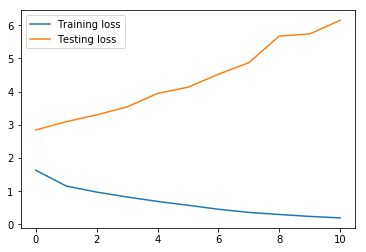

In [41]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']
plt.plot(train_loss, label='Training loss')
plt.plot(test_loss, label='Testing loss')
plt.legend()

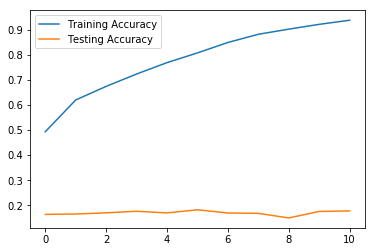

In [42]:
train_acc = history.history['acc']
test_acc = history.history['val_acc']
plt.plot(train_acc, label='Training Accuracy')
plt.plot(test_acc, label='Testing Accuracy')
plt.legend()

**Save Final Keras FFRNN to Disk**

In [43]:
model.save('../models/rnn')

## Factorizing Text Example

### Preprocessing

In [45]:
# Using medium English library which does not include vectors
nlp = spacy.load('en_core_web_md')

In [ ]:
# def preprocess_to_df(par_file, nlp=nlp, sw=['the','a','but','like','for'], to_stem=False):
#     # Run spaCy process on each paragraph and store docs in list
#     print('nlp of paragraphs...')
#     par_nlp = []
#     for par in tqdm(par_file.paragraph):
#         par_nlp.append(nlp(par))
    
#     # Store paragraph lemma from spaCy docs
#     print('nlp lemmatizing, part-of-speech, stopwords...')
#     par_lemma = []
#     for par in tqdm(par_nlp):
#         par_lemma.append([token.lemma_ for token in par     # List comprehension
#                            if token.lemma_ != '-PRON-'           # Pronouns are excluded
#                            and token.pos_ != 'PUNCT'             # Punctionation is excluded
#                            and token.is_alpha                    # Numbers are excluded
#                            and not token.is_stop                 # Stop words are excluded
#                           and len(token.lemma_) > 1])               
    
#     # Stem lemma with NLTK PorterStemmer and remove stop words
#     print('additional stopwords...')
#     if to_stem: ps = PorterStemmer()
#     par_lemma_sw = []
#     for vec_list in tqdm(par_lemma):    
#         update_list = []
#         for token in vec_list:
#             if token in sw: continue
#             if to_stem: update_list.append(ps.stem(token))
#             else: update_list.append(token)
#         par_lemma_sw.append(update_list)
    
#     # Run spaCy on each sentence doc: Text
#     print('saving sentence text...')
#     sent_text = []
#     for par in tqdm(par_nlp):
#         sent_list = []
#         for s in par.sents:
#             sent_list.append(s.text)
#         sent_text.append(sent_list)
    
#     # Run spaCy on each sentence doc: NLP
#     print('nlp of sentences...')
#     sent_nlp = []
#     for par in tqdm(par_nlp):
#         sent_list = []
#         for s in par.sents:
#             sent_list.append(nlp(s.text))
#         sent_nlp.append(sent_list)
    
#     # Store lemma from spaCy docs
#     print('nlp lemmatizing, part-of-speech, stopwords...')
#     sent_lemma = []
#     for par in tqdm(sent_nlp):
#         for sent in par:
#             sent_lemma.append([token.lemma_ for token in sent     # List comprehension
#                                if token.lemma_ != '-PRON-'           # Pronouns are excluded
#                                and token.pos_ != 'PUNCT'             # Punctionation is excluded
#                                and token.is_alpha                    # Numbers are excluded
#                                and not token.is_stop                 # Stop words are excluded
#                               and len(token.lemma_) > 1])               
    
#     # Stem lemma with NLTK PorterStemmer and remove stop words
#     print('additional stopwords...')
#     if to_stem: ps = PorterStemmer()
#     sent_lemma_sw = []
#     for vec_list in tqdm(sent_lemma):    
#         update_list = []
#         for token in vec_list:
#             if token in sw: continue
#             if to_stem: update_list.append(ps.stem(token))
#             else: update_list.append(token)
#         sent_lemma_sw.append(update_list)
    
#     print('constructing dataframe...')
#     nlp_df = pd.DataFrame(columns=['author','work','a_num','w_num','p_num','s_num',
#                                     'sent_text','sent_lemma','par_text','par_lemma'])

#     a_num = 0
#     w_num = 0
#     p_num = 0

#     for p, sents_in_par in enumerate(tqdm(sent_text)):
#         for s, sent in enumerate(sents_in_par):
#             nlp_df = nlp_df.append({'author':par_file.loc[p, 'author'], 
#                                     'work':par_file.loc[p, 'work'], 
#                                     'a_num':a_num,
#                                     'w_num':w_num,
#                                     'p_num':p_num,
#                                     's_num':s,
#                                     'sent_text':sent,
#                                     'par_text':par_file.loc[p, 'paragraph'],
#                                     'par_lemma':par_lemma_sw[p]
#                                     }, ignore_index=True)
#         p_num += 1
#         if p == par_file.shape[0]-1: continue
#         if par_file.loc[p,'work'] != par_file.loc[p+1,'work']:
#             p_num = 0
#             w_num += 1
#             if par_file.loc[p,'author'] != par_file.loc[p+1,'author']:
#                 a_num += 1

#     nlp_df['sent_lemma'] = sent_lemma_sw
#     print('complete')
#     return nlp_df

In [ ]:
def preprocess_to_df(par_file, nlp=nlp, sw=['the','a','but','like','for'], to_stem=False):
    # Run spaCy process on each paragraph and store docs in list
    print('1/8: nlp of paragraphs...')
    par_nlp = []
    for par in tqdm(par_file.paragraph):
        par_nlp.append(nlp(par))
    
    # Store paragraph lemma from spaCy docs
    print('2/8: nlp lemmatizing, part-of-speech, stopwords...')
    par_lemma = []
    for par in tqdm(par_nlp):
        par_lemma.append([token.lemma_ for token in par     # List comprehension
                           if token.lemma_ != '-PRON-'           # Pronouns are excluded
                           and token.pos_ != 'PUNCT'             # Punctuation is excluded
                           and token.is_alpha                    # Numbers are excluded
                           and not token.is_stop                 # Stop words are excluded
                          and len(token.lemma_) > 1])
    par_lemma = [[pl[i].lower() for i in range(len(pl))] for pl in par_lemma]
    
    # Stem lemma with NLTK PorterStemmer and remove stop words
    print('3/8: additional stopwords...')
    if to_stem: ps = PorterStemmer()
    par_lemma_sw = []
    for vec_list in tqdm(par_lemma):    
        update_list = []
        for token in vec_list:
            if token in sw: continue
            if to_stem: update_list.append(ps.stem(token))
            else: update_list.append(token)
        par_lemma_sw.append(update_list)
    
    # Run spaCy on each sentence doc: Text
    print('4/8: saving sentence text...')
    sent_text = []
    for par in tqdm(par_nlp):
        sent_list = []
        for s in par.sents:
            sent_list.append(s.text)
        sent_text.append(sent_list)
    
    # Run spaCy on each sentence doc: NLP
    print('5/8: nlp of sentences...')
    sent_nlp = []
    for par in tqdm(par_nlp):
        sent_list = []
        for s in par.sents:
            sent_list.append(nlp(s.text))
        sent_nlp.append(sent_list)
    
    # Store lemma from spaCy docs
    print('6/8: nlp lemmatizing, part-of-speech, stopwords...')
    sent_lemma = []
    for par in tqdm(sent_nlp):
        for sent in par:
            sent_lemma.append([token.lemma_ for token in sent     # List comprehension
                               if token.lemma_ != '-PRON-'           # Pronouns are excluded
                               and token.pos_ != 'PUNCT'             # Punctuation is excluded
                               and token.is_alpha                    # Numbers are excluded
                               and not token.is_stop                 # Stop words are excluded
                              and len(token.lemma_) > 1])
    sent_lemma = [[sl[j].lower() for j in range(len(sl))] for sl in sent_lemma]
    
    # Stem lemma with NLTK PorterStemmer and remove stop words
    print('7/8: additional stopwords...')
    if to_stem: ps = PorterStemmer()
    sent_lemma_sw = []
    for vec_list in tqdm(sent_lemma):    
        update_list = []
        for token in vec_list:
            if token in sw: continue
            if to_stem: update_list.append(ps.stem(token))
            else: update_list.append(token)
        sent_lemma_sw.append(update_list)
    
    print('8/8: constructing dataframe...')
    nlp_df = pd.DataFrame(columns=['author','work','a_num','w_num','p_num','s_num',
                                    'sent_text','sent_lemma','par_text','par_lemma'])

    a_num = 0
    w_num = 0
    p_num = 0

    for p, sents_in_par in enumerate(tqdm(sent_text)):
        for s, sent in enumerate(sents_in_par):
            nlp_df = nlp_df.append({'author':par_file.loc[p, 'author'], 
                                    'work':par_file.loc[p, 'work'], 
                                    'a_num':a_num,
                                    'w_num':w_num,
                                    'p_num':p_num,
                                    's_num':s,
                                    'sent_text':sent,
                                    'par_text':par_file.loc[p, 'paragraph'],
                                    'par_lemma':par_lemma_sw[p]
                                    }, ignore_index=True)
        p_num += 1
        if p == par_file.shape[0]-1: continue
        if par_file.loc[p,'work'] != par_file.loc[p+1,'work']:
            p_num = 0
            w_num += 1
            if par_file.loc[p,'author'] != par_file.loc[p+1,'author']:
                a_num += 1

    nlp_df['sent_lemma'] = sent_lemma_sw
    print('complete')
    return nlp_df

In [ ]:
def nlp_factorize(lda_df, model=model_full, ss=ss):
    lda_sc = ss.transform(lda_df.values)    
    preds = model.predict_proba(lda_sc)
    return preds

### Display Results

In [ ]:
def display_nlp_factors(preds, raw_text, doc_number=0, thresh=0.01, target_authors=None):
    print('-'*30)
    print('Doc #:', doc_number)
    if target_authors: print('Target Author:', target_authors[doc_number])
    print('Text:\n', raw_text[doc_number])
    print('\nPhilosophical Factors:\n')
    
    result_list = [(text_data.Author.unique()[i], preds[doc_number][i]) for i in range(len(text_data.Author.unique()))]
    result_list.sort(key=lambda tup: tup[1], reverse=True)
    
    for j in range(len(text_data.Author.unique())):
        n_sp = 35 - len(result_list[j][0])
        if result_list[j][1] >= thresh:
            print('\t{}{}{}'.format(result_list[j][0],str(' '*n_sp),str(round(result_list[j][1], 3))))
    print('-'*30)

In [ ]:
babbage = """
There are few circumstances which so strongly distinguish the philosopher, 
as the calmness with which he can reply to criticisms he may think...
"""

## Continue to Notebook 5: Factorizing Unseen Text